<a href="https://colab.research.google.com/github/predicthq/phq-data-science-docs/blob/master/severe-weather-events/part_2_data_exploration.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##### Severe Weather Data Science Guides

# Part 2: Data Exploration

<b>A How To Guide to exploring PredictHQ Severe Weather events data covering:</b>


# Severe weather sections

- [Setup](#setup)
- [Types of Severe Weather](#tsv)
- [Polygons](#polygons)
- [Severe Weather and Geography](#geography)
- [Severe Weather Timelines](#timeline)
- [Example Storms](#named)
- [Demand Impact Patterns](#impact)
- [Duration](#duration)
- [Rank Distribution](#rank)
- [First Seen](#first_seen)

# Sample Data
## Chicago, Jacksonville, Seattle, New York, Hurricane Dorian

Severe weather events are currently in beta. PredictHQ will provide advice and support on how to use severe weather in your forecast. Please contact us if you would like to participate in the beta. Provided alongside this notebooks is a sample of data that relates to severe weather events in New York, Chicago, Jacksonville and Seattle during 2018 and 2019, along with events related to Hurricane Dorian. Please contact us if you would like access to more data. If you have access to severe weather through our API this notebook can be adjusted to review the data from locations of interest to you.

<a id='setup'></a>
## Setup

If using Google Colab uncomment the following code block.

In [1]:
# %%capture
# !git clone https://github.com/predicthq/phq-data-science-docs.git
# %cd phq-data-science-docs/severe-weather
# !pip install predicthq

If running locally, set up a Python environment using ```requirements.txt``` shared alongside the notebook to install the required dependancies.

In [44]:
import pandas as pd
import datetime
from datetime import timedelta

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import shapely
from shapely import geometry
from shapely.geometry import Point
from geopy.distance import geodesic

import folium
from folium import plugins, FeatureGroup, Marker, Popup, Tooltip, Circle
from folium.plugins import HeatMap, MarkerCluster
import geopandas as gpd

from predicthq import Client
import rfc3339
import pytz

In [45]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


<a id='tsv'></a>
# Types of Severe Weather

It is recommended to use 13 subcategories of severe weather. The following logic is used to assign each event to a subcategory. 

In [47]:
df = pd.read_pickle("data/event_data/sample_data_new.pkl")

In [48]:
df.columns

Index(['id', 'title', 'description', 'start', 'end', 'duration', 'category',
       'labels', 'country', 'rank', 'aviation_rank', 'location',
       'place_hierarchies', 'scope', 'first_seen', 'impact_patterns', 'geo',
       'timezone'],
      dtype='object')

In [49]:
df.start

0     2019-12-30 16:59:00+00:00
1     2019-12-02 16:29:00+00:00
2     2019-11-18 15:00:00+00:00
3     2019-11-17 14:00:00+00:00
4     2019-11-09 05:00:00+00:00
                 ...           
459   2018-02-04 09:23:00+00:00
460   2018-02-04 08:00:00+00:00
461   2018-01-30 00:00:00+00:00
462   2018-01-11 12:00:00+00:00
463   2018-01-05 15:00:00+00:00
Name: start, Length: 464, dtype: datetime64[ns, tzutc()]

In [50]:
df["start_date"] = pd.to_datetime(df.start.astype(str).str[0:10])

In [51]:
df["polygon_data"] = df.geo.apply(lambda geo: geo["geometry"]["coordinates"])
df["polygon_type"] = df.geo.apply(lambda geo: geo["geometry"]["type"])

In [52]:
def create_shapely_polygon_object(row):
    if len(row["polygon_data"]) == 1:
        row["polygon"] = geometry.Polygon(row["polygon_data"][0])

    elif len(row["polygon_data"]) > 1:
        polygons = []
        for polygon in row["polygon_data"]:
            polygons.append(geometry.Polygon(polygon[0]))
        row["polygon"] = geometry.MultiPolygon(polygons)

    return row


df = df.apply(create_shapely_polygon_object, axis=1)

/home/andrew/.local/lib/python3.8/site-packages/pandas/core/dtypes/cast.py:1990: ShapelyDeprecationWarning:

__len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.



In [53]:
def get_area(row):
    """Find area of event polygon"""
    if row.polygon_type == "Multipolygon":
        total_area = 0
        for polygon in row.polygon:
            total_area = total_area + polygon.area

    else:
        row["polygon_area"] = row.polygon.area

    return row


df = df.apply(get_area, axis=1)

In [54]:
df[["lon", "lat"]] = pd.DataFrame(df.location.tolist(), index=df.index)

In [55]:
def map_event_to_subcategory(labels):

    """Assign an event to a subcategory using the labels.
    Reduces the events to 13 event subcategories"""

    if "blizzard" in labels:
        return "blizzard"

    if "snow" in labels:
        return "cold-wave-snow"

    if "cold-wave" in labels:
        if "storm" in labels:
            return "cold-wave-storm"
        else:
            return "cold-wave"

    if ("air-quality" in labels) or ("fog" in labels) or ("sand" in labels):
        return "air-quality"

    if "thunderstorm" in labels:
        return "thunderstorm"

    if "tropical-storm" in labels:
        return "tropical-storm"

    if "tornado" in labels:
        return "tornado"

    if ("hurricane" in labels) or ("cyclone" in labels) or ("typhoon" in labels):
        return "hurricane"

    if "dust" in labels:
        if "storm" in labels:
            return "dust-storm"
        else:
            return "dust"

    if ("rain" in labels) or ("flood" in labels) or ("coastal-event" in labels):
        return "flood"

    if "heat-wave" in labels:
        return "heat-wave"

    if ("wind" in labels) or ("hazardous-surf" in labels):
        return "dust-storm"

    if "storm" in labels:
        return "dust-storm"

    return None

In [56]:
df["subcategory"] = df.labels.apply(map_event_to_subcategory)

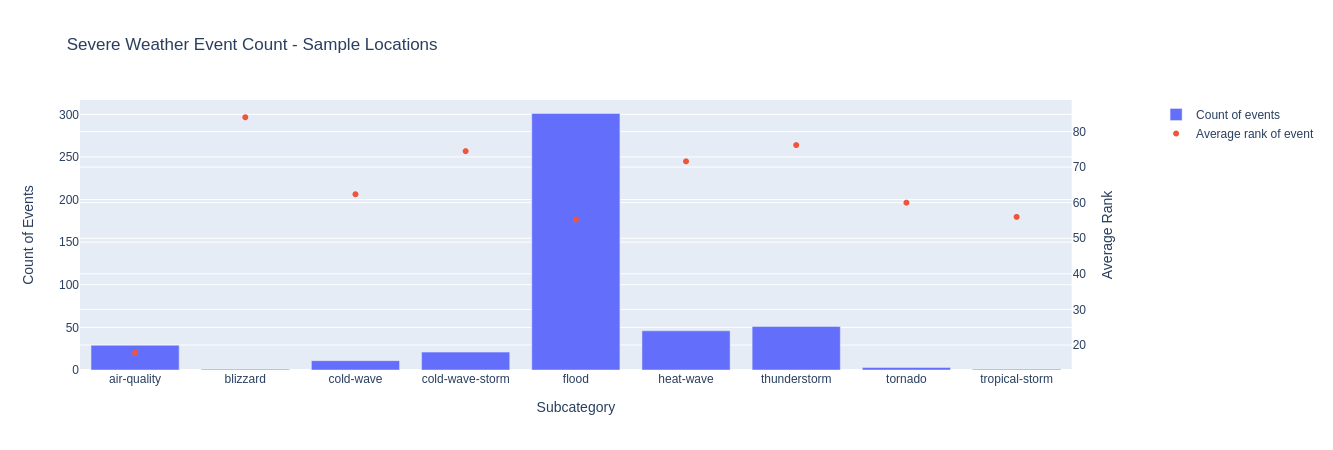

In [57]:
# Bar plot count for different types of severe weather subcategory.
severe_weather_types = df.groupby("subcategory", as_index=False).agg(
    count_of_events=("rank", "count"), average_rank=("rank", "mean")
)

fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(
        x=severe_weather_types["subcategory"],
        y=severe_weather_types["count_of_events"],
        name="Count of events",
    ),
)
fig.add_trace(
    go.Scatter(
        x=severe_weather_types["subcategory"],
        y=severe_weather_types["average_rank"],
        name="Average rank of event",
        mode="markers",
    ),
    secondary_y=True,
)

fig.update_layout(title_text="Severe Weather Event Count - Sample Locations")

fig.update_xaxes(title_text="Subcategory")
fig.update_yaxes(title_text="Count of Events", secondary_y=False)
fig.update_yaxes(title_text="Average Rank", secondary_y=True)

fig.show()

Some subcategories of severe weather are more or less common than others. A sparse subcategory may be more impactful on demand than a very common event subcategory.

In [58]:
m = folium.Map([39.74977861766632, -104.99801768826767], zoom_start=4)

for subcat in df.subcategory.unique():
    data_temp = [
        [row["lat"], row["lon"]]
        for index, row in df[df.subcategory == subcat].iterrows()
    ]

    plugins.MarkerCluster(data_temp, name=subcat).add_to(m)

folium.LayerControl(collapsed=False).add_to(m)

m

Different subcategories of severe weather are present in different geographic locations. The above visual allows an analysis of the count of different subcategories in different locations based on the sample data.  

<a id='polygons'></a>
# Polygons

PredictHQ severe weather data includes GeoJson data that allows the construction of polygons. Without polygons a user would need to use the centroid latitude and longitude of the event. This approach would risk certain events not being included as impacting a certain location. 

The following code shows a number of example events, with both the polygon and centroid plotted to allow for comparison. 

In [59]:
df_temp = df[0:100].copy()

m = folium.Map(
    location=(41.88964496293642, -87.63037288239376),
    zoom_start=6,
    tiles="CartoDB positron",
)

# Plot each events polygon and the centroid of the event.
for _, r in df_temp.iterrows():

    # Polygon plot
    if r["polygon_type"] == "Polygon":

        sim_geo = gpd.GeoSeries(r.polygon).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(
            data=geo_j, style_function=lambda x: {"fillColor": "red", "opacity": 0.001}
        )
        folium.Popup(
            f"""{r.subcategory} <br>
                                     """,
            min_width=50,
            max_width=200,
            show=False,
        ).add_to(geo_j)
        geo_j.add_to(m)

    elif r["polygon_type"] == "Multipolygon":
        for polygon in r["polygon"]:
            sim_geo = gpd.GeoSeries(polygon).simplify(tolerance=0.001)
            geo_j = sim_geo.to_json()
            geo_j = folium.GeoJson(
                data=geo_j,
                style_function=lambda x: {"fillColor": "red", "opacity": 0.001},
            )
            folium.Popup(
                f"""{r.subcategory} <br>
                             """,
                min_width=50,
                max_width=200,
                show=False,
            ).add_to(geo_j)
            geo_j.add_to(m)

    # Centroid plot
    folium.Marker(location=[r.lat, r.lon]).add_to(m)
m

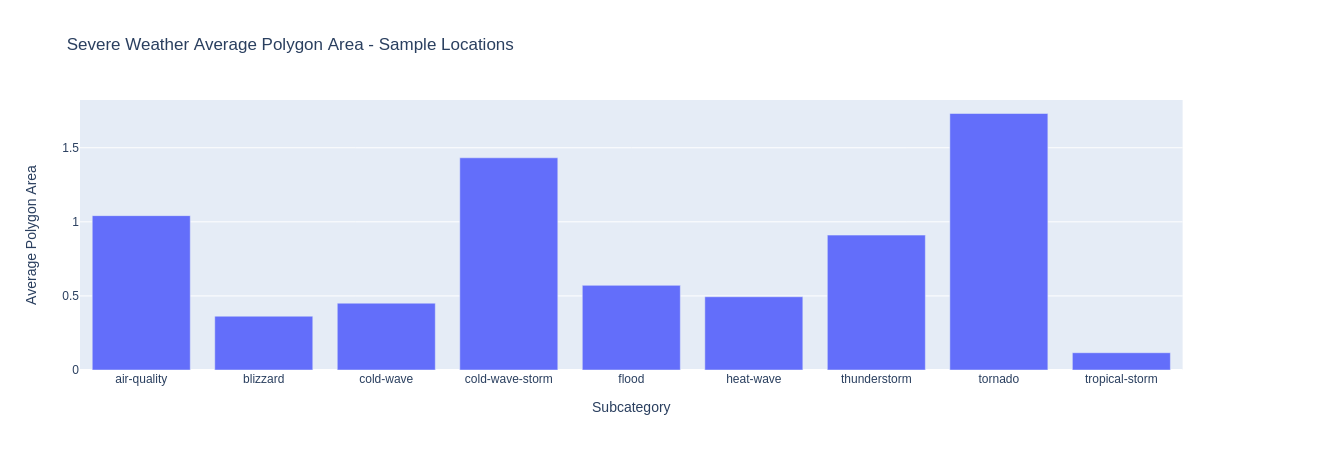

In [60]:
# Compare the average area of polygons for each event type
severe_weather_types = df.groupby("subcategory", as_index=False).agg(
    polygon_area_sum=("polygon_area", "sum"),
    polygon_area_average=("polygon_area", "mean"),
)

# Use plotly to visualize results
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Bar(
        x=severe_weather_types["subcategory"],
        y=severe_weather_types["polygon_area_average"],
        name="Average Polygon Area",
    )
)

fig.update_layout(title_text="Severe Weather Average Polygon Area - Sample Locations")

fig.update_xaxes(title_text="Subcategory")
fig.update_yaxes(title_text="Average Polygon Area", secondary_y=False)
fig.update_yaxes(title_text="Count of Events", secondary_y=True)

fig.show()

By using polygons, the area of an event can be compared rather than just the count. From previous analysis the count of flood events is high, but here we can see that the average polygon area for floods is low. The impact of an event subcategory will depend on both the count, the event type and the size of the polygons.

# Polygon Geometry

Different types of events demonstrate different geometry characteristics. Floods tend to follow the route of rivers. 

In [61]:
def get_minimum_box_width_length(row):
    """
    Calculate the min width and min length of the minimum rectangle that
    can contain the polygon.
    """

    if row.polygon_type == "Multipolygon":
        row["width_length_ratio"] = None
    else:
        box = row.polygon.minimum_rotated_rectangle
        x, y = box.exterior.coords.xy
        edge_length = (
            Point(x[0], y[0]).distance(Point(x[1], y[1])),
            Point(x[1], y[1]).distance(Point(x[2], y[2])),
        )
        # get length of polygon as the longest edge of the bounding box
        row["length"] = max(edge_length)
        # get width of polygon as the shortest edge of the bounding box
        row["width"] = min(edge_length)

        row["width_length_ratio"] = row["width"] / row["length"]
    return row

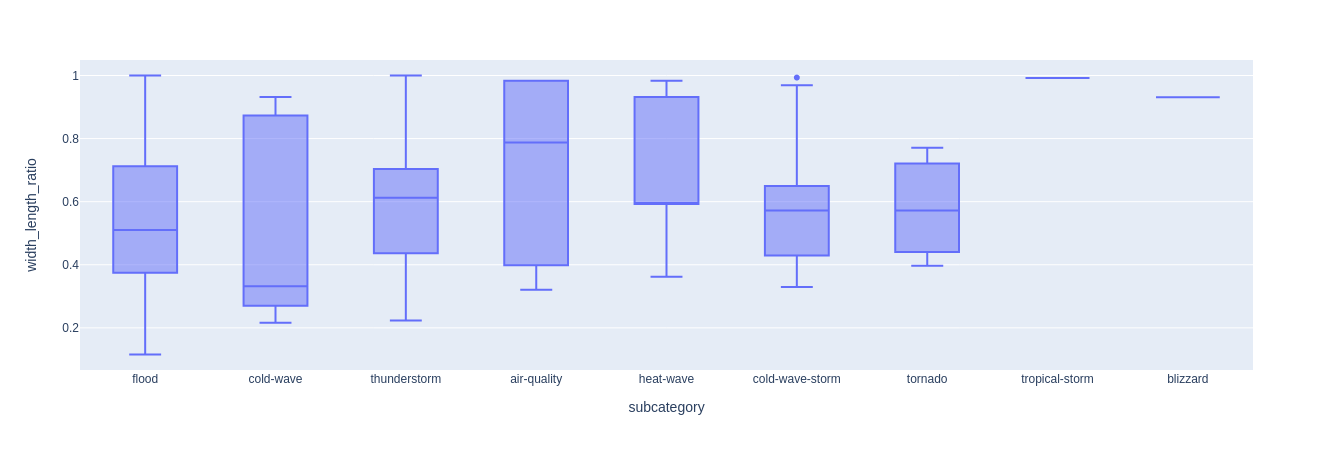

In [62]:
df = df.apply(get_minimum_box_width_length, axis=1)


fig = px.box(df, x="subcategory", y="width_length_ratio")
fig.show()

Floods have a notably different distribution of width to length ratios, explained by the fact these event types often follow the route of rivers. This means that a flood may not uniformly affect the whole area around a location, but instead be more localised to the area around a river. This can influence how much the flood impacts demand.

<a id='geography'></a>
# Severe Weather and Geography


The type of severe weather event varies by geography. Remember when analysing these results that this is dependant on the dataset used alongside the notebook. 

In [63]:
# Provide polygon map visualisation of the different categories.


def polygon_map_per_type(df, type_of_event):
    """
    Create a map of polygons just for data related to a specific type of severe weather.
    inputs - df - dataframe of events
    type_of_event - the subcategory of severe weather to plot.
    """
    # Filter the events data for only that subcategory.
    event_data = df[df.title.str.contains(type_of_event)].copy()
    print(f"Total number of events {len(event_data)}")

    m = folium.Map(location=(39.74977861766632, -104.99801768826767), zoom_start=4)
    for _, r in event_data.iterrows():

        # Polygon plot
        sim_geo = gpd.GeoSeries(r["polygon"]).simplify(tolerance=0.001)
        geo_j = sim_geo.to_json()
        geo_j = folium.GeoJson(
            data=geo_j, style_function=lambda x: {"fillColor": "red", "opacity": 0.5}
        )
        folium.Popup(
            f"""{r.subcategory} <br>
                     """,
            min_width=50,
            max_width=200,
            show=False,
        ).add_to(geo_j)
        geo_j.add_to(m)

    display(m)

In [64]:
polygon_map_per_type(df, "Hurricane")

Total number of events 0


In [21]:
polygon_map_per_type(df, "Tropical")

Total number of events 1


In [16]:
polygon_map_per_type(df, "Winter")

Total number of events 127


<a id='timeline'></a>
# Severe Weather Timelines

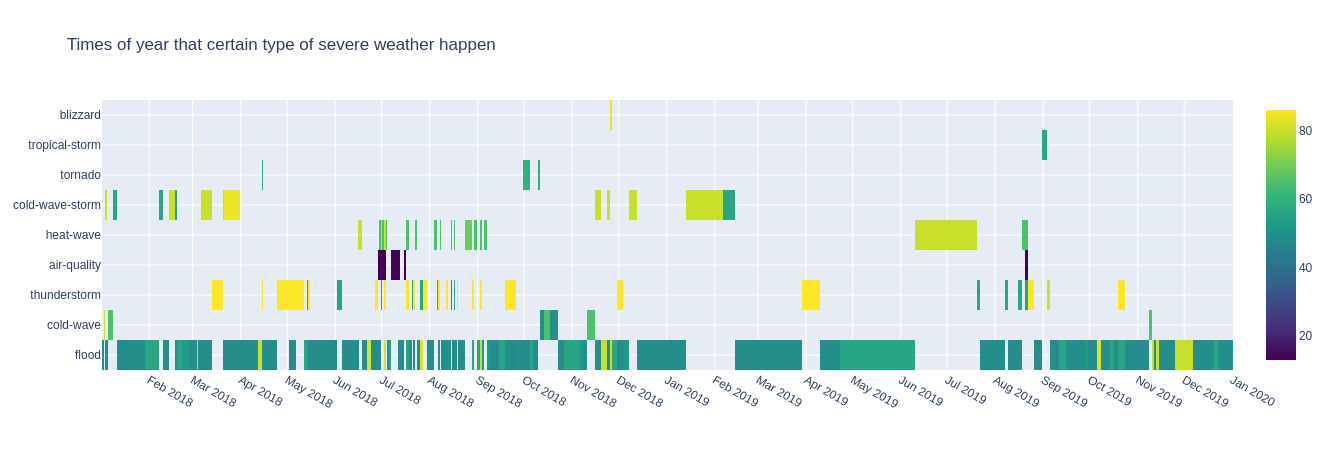

In [65]:
fig = go.Figure(
    data=go.Heatmap(
        z=df["rank"], x=df.start_date, y=df.subcategory, colorscale="Viridis"
    )
)

fig.update_layout(
    title="Times of year that certain type of severe weather happen", xaxis_nticks=36
)

fig.show()

Certain events such as floods happen all year round. There are notable seasons for hurricanes and tropical storms. Hot and cold weather events are also obviously seasonal. 

<a id='impact'></a>
# Demand Impact Patterns 



Demand impact patterns help you to understand the impact of an event in the days leading up to an event and the days after an event. With Severe Weather the impact on business is rarely constrained to the day of the event itself. Details of how we created impact patterns can be found on our website. In this section of the notebook we provide some code exammples to help you visualise and explore the demand impact patterns so you can better understand what they are. In the third notebook we'll look at how to expand and use these demand impact patterns in forecasting. Here we'll get more familiar with the data structure. 


In [81]:
# Visualise what the raw data looks like. 
df[~df.impact_patterns.isna()]["impact_patterns"].iloc[0]

[{'vertical': 'retail',
  'impact_type': 'phq_rank',
  'impacts': [{'date_local': datetime.date(2019, 10, 25),
    'value': 10,
    'position': 'leading'},
   {'date_local': datetime.date(2019, 10, 26),
    'value': 27,
    'position': 'leading'},
   {'date_local': datetime.date(2019, 10, 27),
    'value': 53,
    'position': 'event_day'}]}]

Next we'll plot out one example demand impact pattern for each subcategory of severe weather. The event day is shaded. Note that the demand impact pattern is a feature of many aspects including the subcategory, location and time of year.

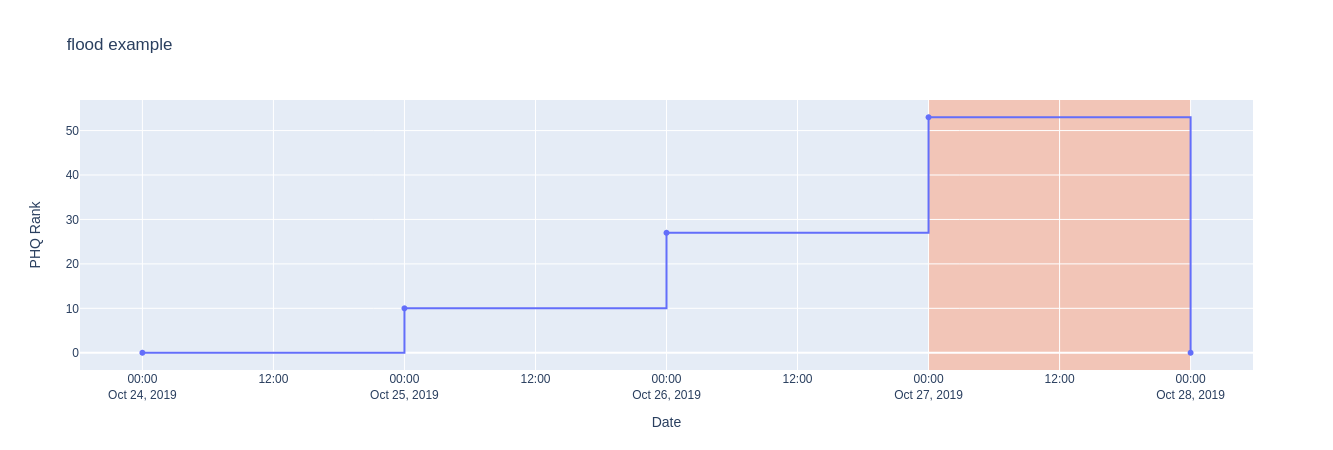

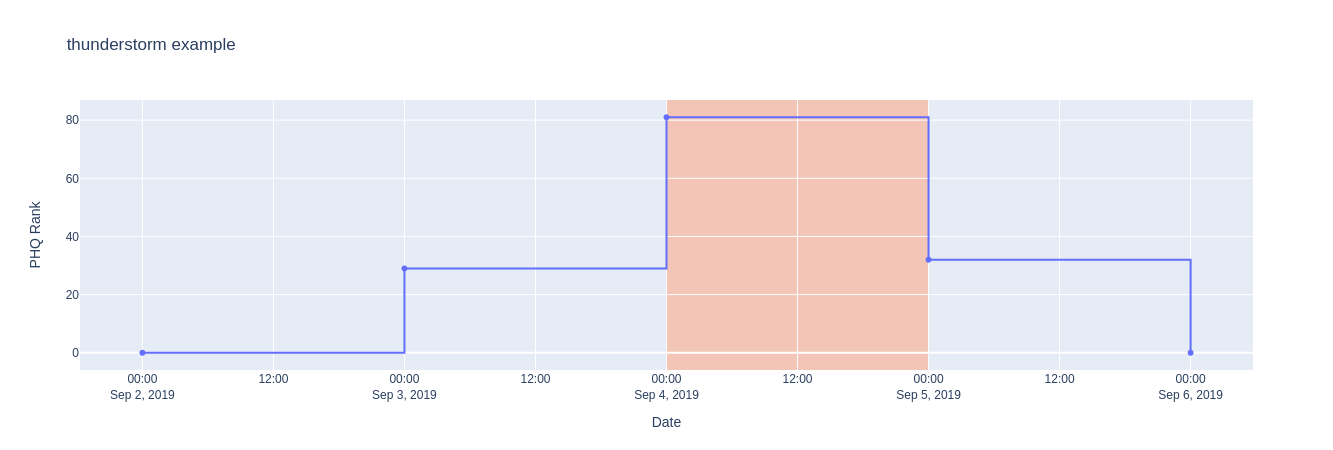

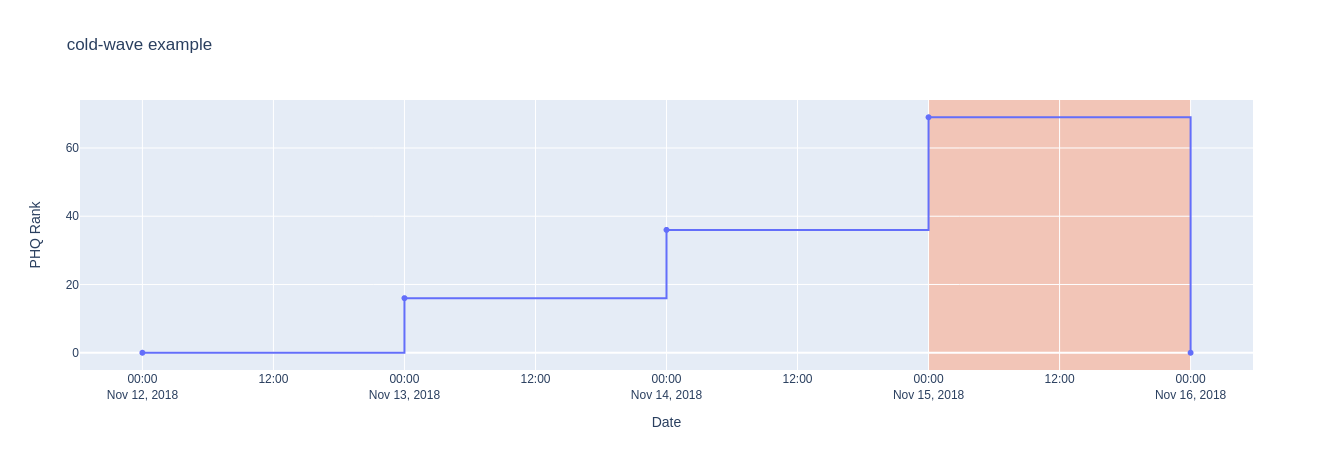

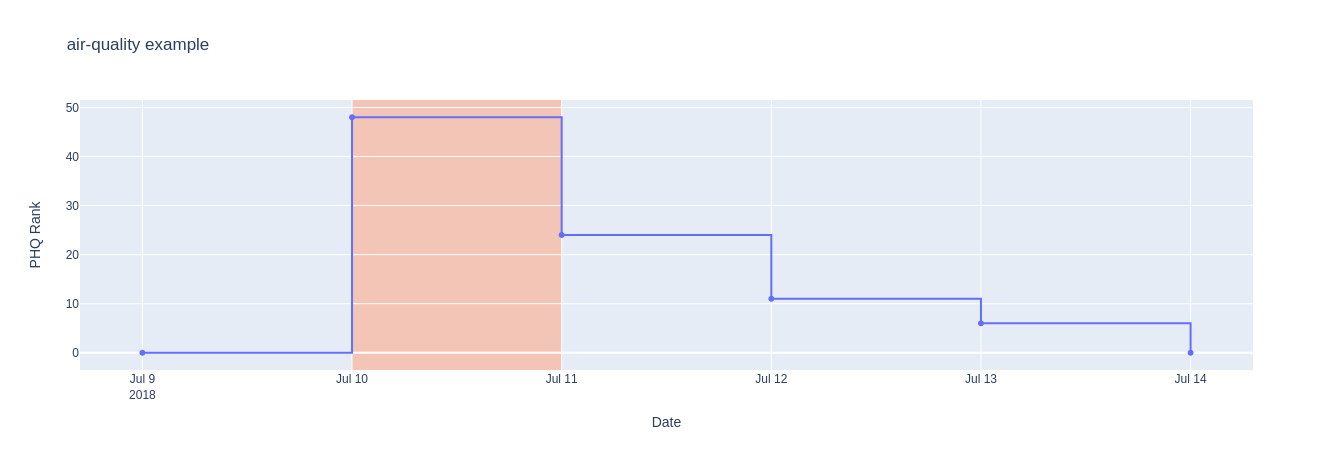

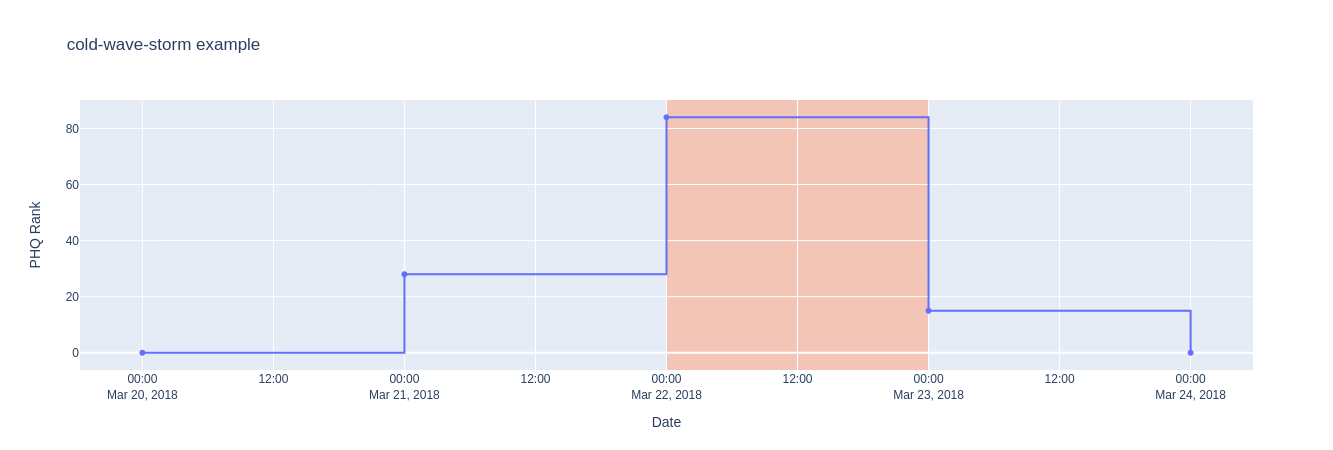

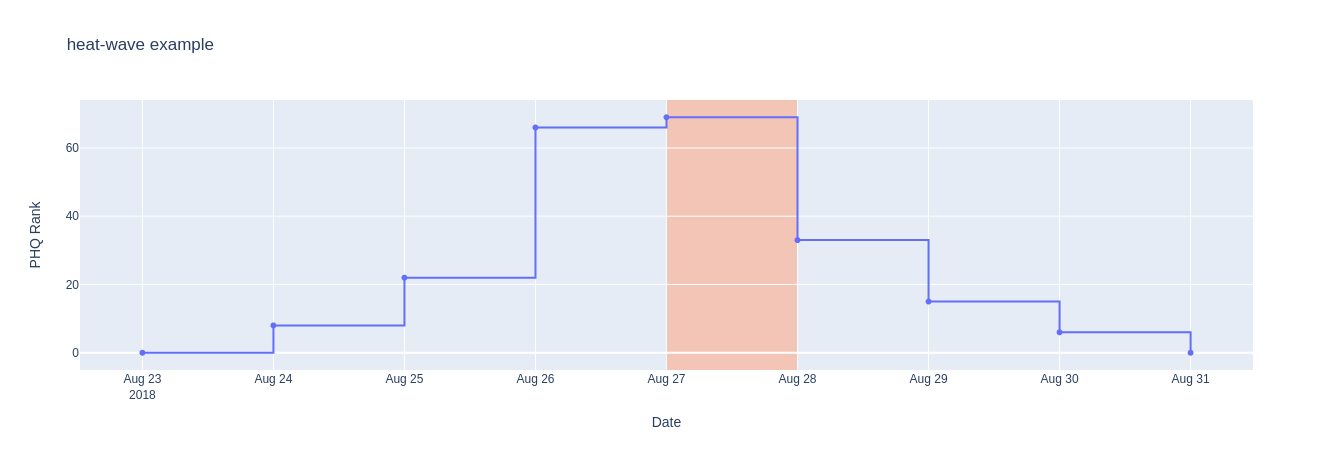

In [83]:
def plot_impact_pattern(impact_to_plot, sub):
    """
    Plot an impact pattern and output display to notebook

        Parameters:
            impact_to_plot (list): List of days that are part of impact pattern.
            sub (string) : the subcategory the example is from
        Returns:
            None
    """
    one_imp = pd.DataFrame(impact_to_plot)

    one_imp = one_imp.append(
        {
            "date_local": one_imp["date_local"][len(one_imp) - 1] + timedelta(days=1),
            "value": 0,
            "position": "zero",
        },
        ignore_index=True,
    )

    one_imp = one_imp.append(
        {
            "date_local": one_imp["date_local"][0] - timedelta(days=1),
            "value": 0,
            "position": "zero",
        },
        ignore_index=True,
    )

    one_imp.sort_values("date_local", inplace=True)

    fig = go.Figure()

    fig.add_trace(
        go.Scatter(x=one_imp.date_local, y=one_imp.value, line={"shape": "hv"})
    )

    date = list(one_imp[one_imp.position == "event_day"]["date_local"])[0]

    fig.add_vrect(
        x0=date + datetime.timedelta(seconds=(24 * 60 * 60)),
        x1=date,
        fillcolor="LightSalmon",
        opacity=0.5,
        layer="below",
        line_width=0,
    )

    fig.update_layout(
        title=f"{sub} example",
        xaxis_title="Date",
        yaxis_title="PHQ Rank",
    )
    fig.show()
    return None


# Explore example from each subcategory
example_subcategories = df[~df.impact_patterns.isna()]["subcategory"].unique()

for sub in example_subcategories:
    # randomly take one of the impact patterns as an example
    impact_to_plot = df[~df.impact_patterns.isna() & (df.subcategory == sub)][
        "impact_patterns"
    ].iloc[0][0]["impacts"]

    plot_impact_pattern(impact_to_plot, sub)

To illustrate that the demand impact patterns are also a function of other features we will compare demand impact patterns from the same subcategory to show they are not the same. 

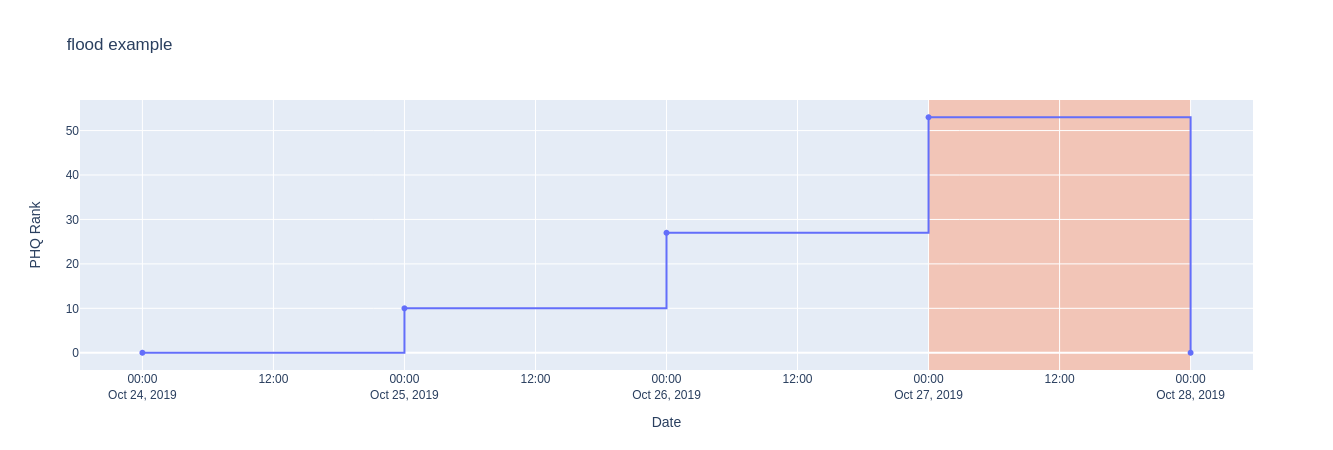

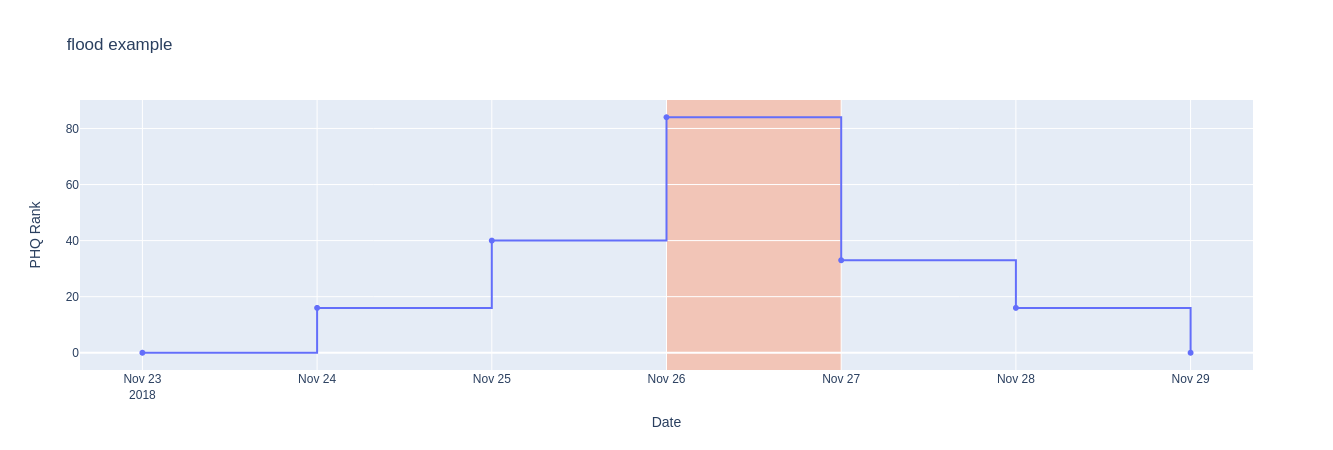

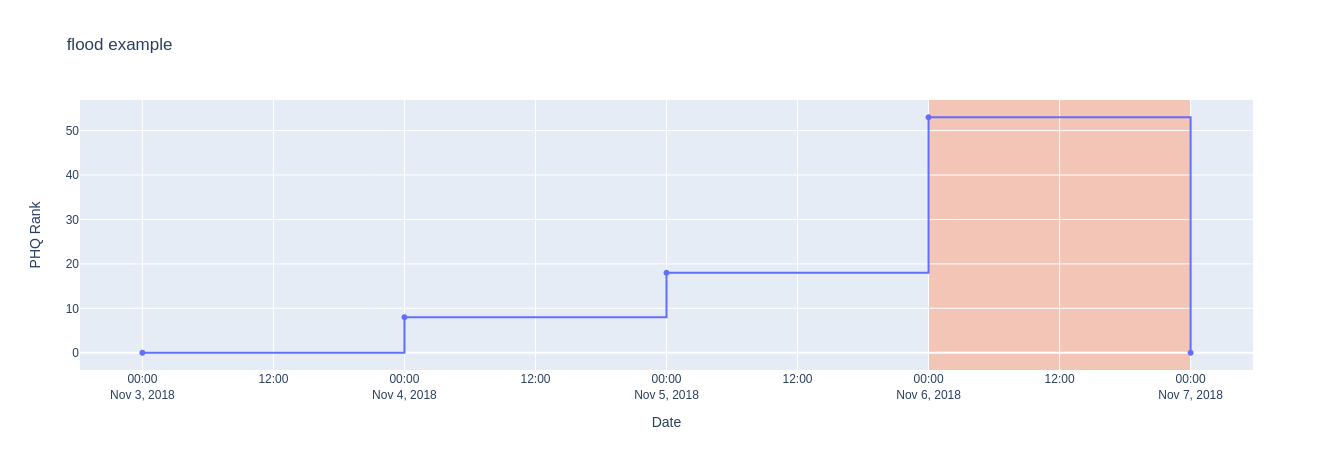

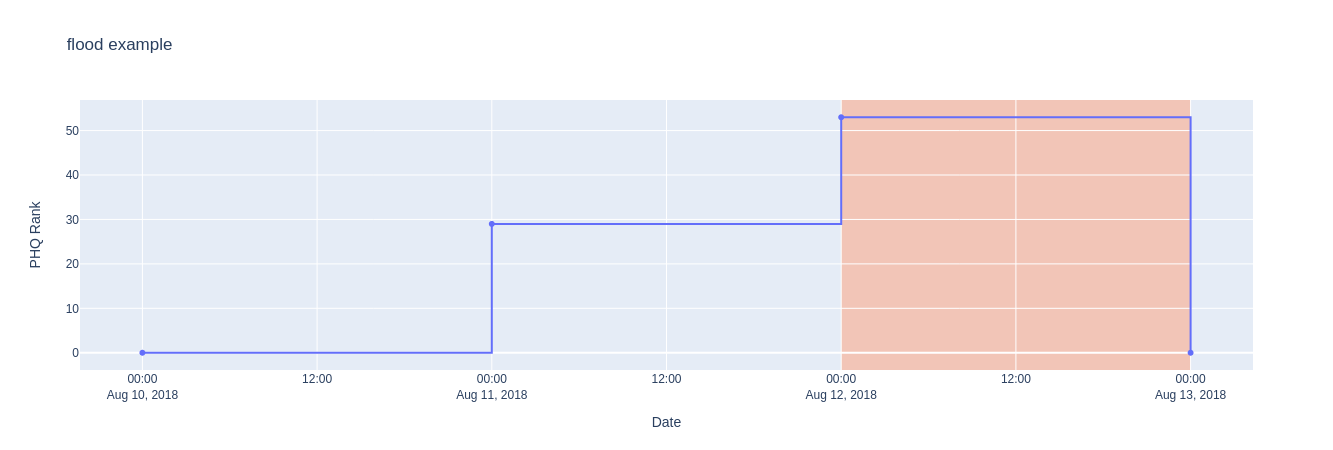

In [84]:
SELECTED_SUBCATEGORY = "flood"

df_impact_to_plot = df[
    ~df.impact_patterns.isna() & (df.subcategory == SELECTED_SUBCATEGORY)
]

for index, row in df_impact_to_plot[0:4].iterrows():
    impact_to_plot = row["impact_patterns"][0]["impacts"]

    plot_impact_pattern(impact_to_plot, "flood")

# Specific Examples

### Hurricane Dorian

August 27 to September 9 2019

In [31]:
df["start_date_string"] = df.start_date.astype(str)

In [32]:
dorian = df[
    (df.start_date_string > "2019-08-23")
    & (df.start_date_string < "2019-09-12")
    & (
        (df.title.str.contains("Tropical"))
        | (df.title.str.contains("Hurricane"))
        | (df.title.str.contains("Flood"))
        | (df.title.str.contains("Tornado"))
        | (df.title.str.contains("Thunderstorm"))
    )
    & (df.lon > -85.30017513067776)
].copy()

In [33]:
dorian.groupby("subcategory").agg(event_count=("title", "count"))

event_count
subcategory                
flood                     2
thunderstorm              2
tropical-storm            1

In [34]:
m = folium.Map(location=(35.815592563523616, -78.70013260052576), zoom_start=5)
for _, r in dorian.iterrows():

    # Polygon plot
    sim_geo = gpd.GeoSeries(r["polygon"]).simplify(tolerance=0.001)
    geo_j = sim_geo.to_json()
    geo_j = folium.GeoJson(
        data=geo_j, style_function=lambda x: {"fillColor": "red", "opacity": 0.01}
    )
    folium.Popup(
        f"""{r.title} <br>
                 """,
        min_width=50,
        max_width=200,
        show=False,
    ).add_to(geo_j)
    geo_j.add_to(m)
m

In [86]:
m = folium.Map((35.815592563523616, -78.70013260052576), zoom_start=5)

# Create data for animations.
features_polygons = [
    {
        "type": "Feature",
        "geometry": {
            "type": "Polygon",
            "coordinates": [
                list(
                    zip(
                        row["polygon"].exterior.coords.xy[0],
                        row["polygon"].exterior.coords.xy[1],
                    )
                )
            ],
        },
        "properties": {
            "times": [row.start_date_string],
        },
    }
    for _, row in dorian[dorian.polygon_type != "Multipolygon"].iterrows()
]

features_multipolygons = []
for _, row in dorian[dorian.polygon_type == "Multipolygon"].iterrows():
    for polygon in row.polygon:
        features_multipolygons.append(
            {
                "type": "Feature",
                "geometry": {
                    "type": "Polygon",
                    "coordinates": [
                        list(
                            zip(
                                polygon.exterior.coords.xy[0],
                                polygon.exterior.coords.xy[1],
                            )
                        )
                    ],
                },
                "properties": {
                    "times": [row.start_date_string],
                },
            }
        )

features = features_multipolygons + features_polygons

plugins.TimestampedGeoJson(
    {
        "type": "FeatureCollection",
        "features": features,
    },
    period="P1D",
    duration="P2D",
    transition_time=500,
    add_last_point=True,
).add_to(m)

display(m)

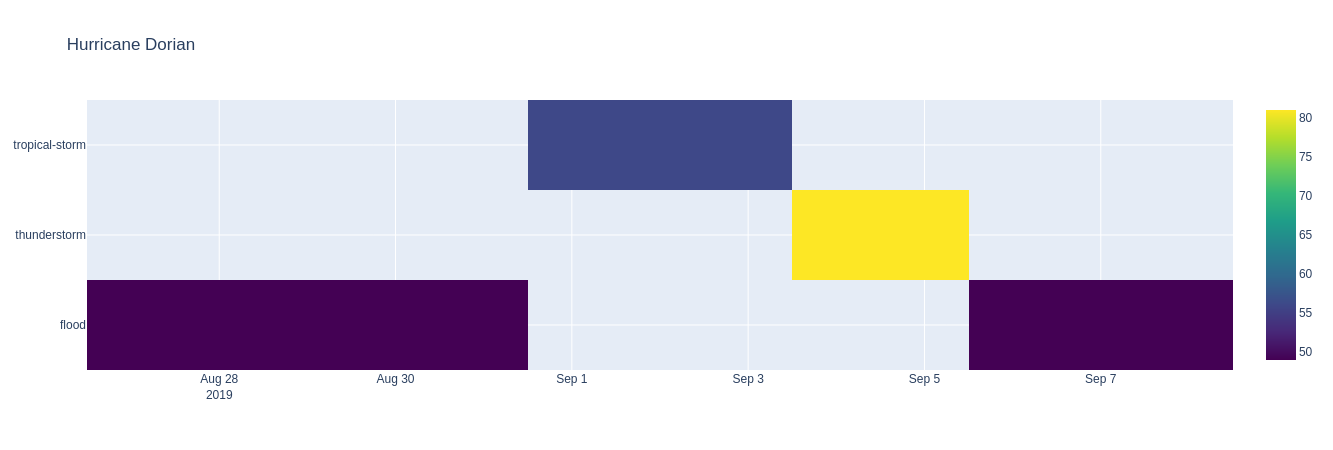

In [87]:
fig = go.Figure(
    data=go.Heatmap(
        z=dorian["rank"],
        x=dorian.start_date,
        y=dorian.subcategory,
        colorscale="Viridis",
    )
)

fig.update_layout(
    title="Hurricane Dorian",
)

fig.show()

<a id='rank'></a>
## Rank Distribution

- No local rank
- No aviation rank

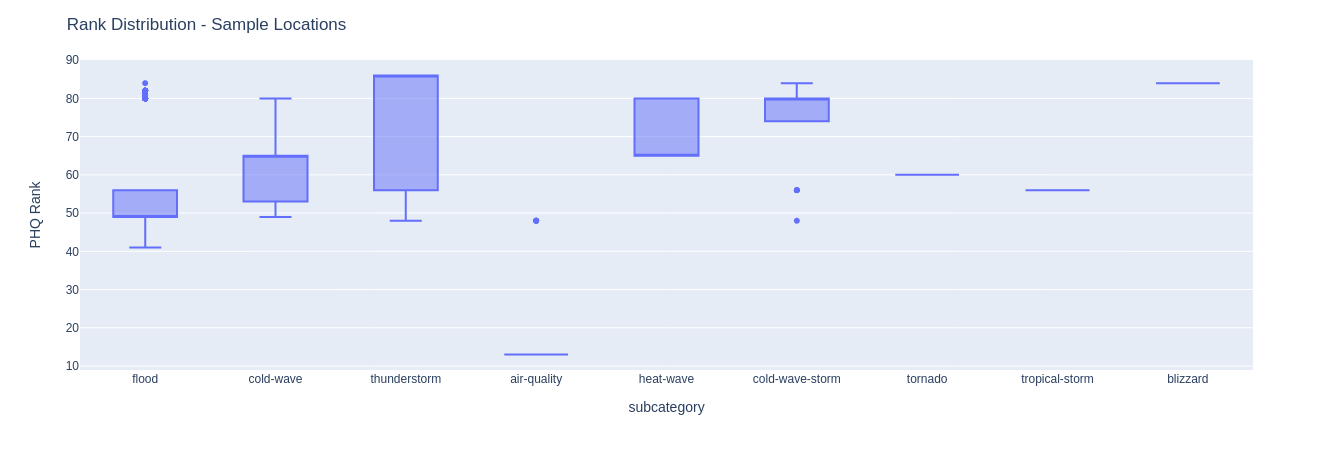

In [88]:
sub_categories = df.subcategory.unique()

fig = px.box(df, x="subcategory", y="rank")

fig.update_layout(title_text="Rank Distribution - Sample Locations")

fig.update_xaxes(title_text="Sub Category", row=1, col=int(len(sub_categories) / 2))
fig.update_yaxes(title_text="PHQ Rank", row=1, col=1)
fig.show()

<a id='duration'></a>
## Duration

In [89]:
df["duration"] = pd.to_datetime(df.end) - pd.to_datetime(df.start)

In [90]:
df["duration_hours"] = (
    (df["duration"].dt.days * 86400) + df["duration"].dt.seconds
) / (60 * 60)

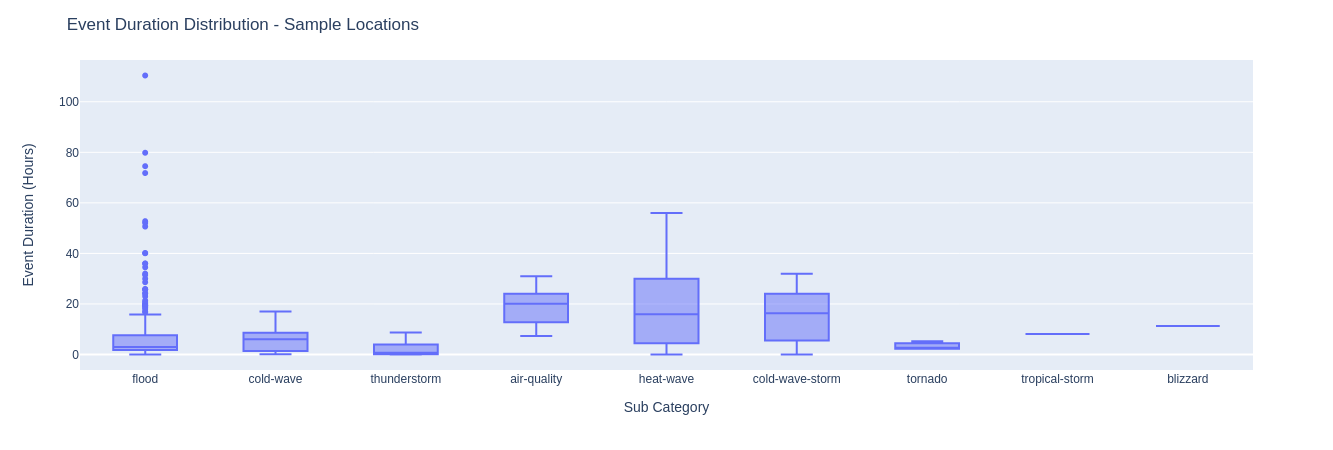

In [91]:
fig = px.box(df, x="subcategory", y="duration_hours")
fig.update_layout(title_text="Event Duration Distribution - Sample Locations")

fig.update_xaxes(title_text="Sub Category", row=1, col=1)
fig.update_yaxes(title_text="Event Duration (Hours)", row=1, col=1)
fig.show()

<a id='first_seen'></a>
## First Seen

In [94]:
df["start_string"] = df["start"].astype(str)

In [95]:
def get_local_dt(dt, tz):
    """
    Localize a datetime for a given timezone.
    Args:
        dt: a datetime in string format.
        tz: timezone to localise to.
    return:
        local_dt: local datetime according to given timezone.
    """
    if not dt:
        return None

    dt = rfc3339.parse_datetime(dt)

    if not tz:
        return dt

    local_dt = dt.astimezone(pytz.timezone(tz))
    return local_dt

In [97]:
df["start_local"] = df.apply(
    lambda row: get_local_dt(row["start_string"], row["timezone"]), axis=1
)

In [98]:
df["start_date"] = df.start_local.map(lambda x: x.date())
df["first_seen_date"] = df.first_seen.map(lambda x: pd.to_datetime(x).date())

In [99]:
df["seen_before"] = pd.to_datetime(df.start_date) - pd.to_datetime(df.first_seen_date)
df["seen_before"] = df["seen_before"].dt.days

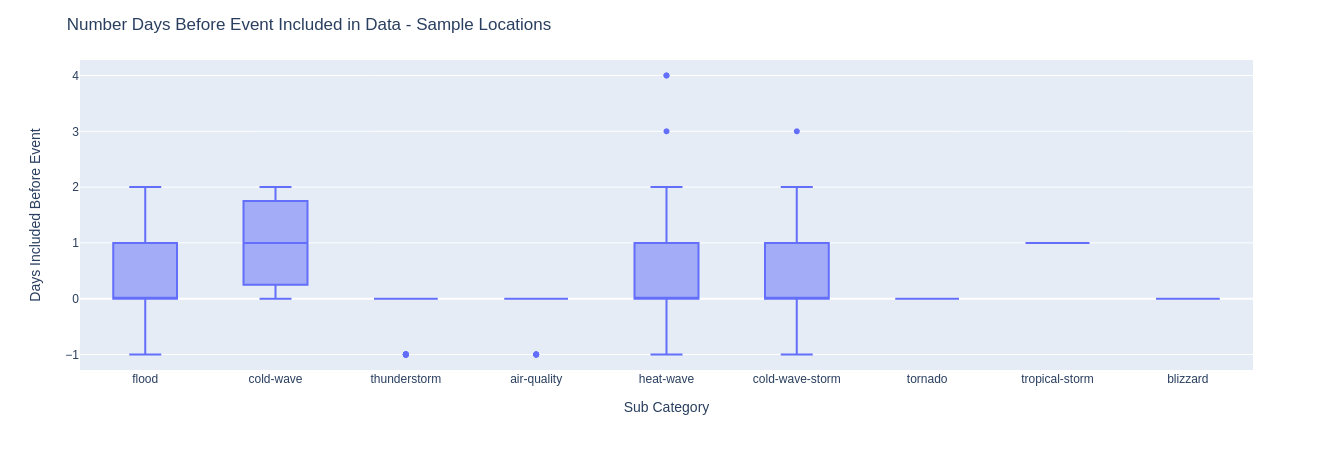

In [100]:
# For this visualisation remove any outliers.
# for example events retrospectively added.
df_first_seen_no_outliers = df[df["seen_before"] > -10].copy()

fig = px.box(df_first_seen_no_outliers, x="subcategory", y="seen_before")

fig.update_layout(
    title_text="Number Days Before Event Included in Data - Sample Locations"
)


fig.update_xaxes(title_text="Sub Category")
fig.update_yaxes(title_text="Days Included Before Event")

fig.show()